# Predictions statistics

Let's analyse the predictions made on our test datasplit.

**Note** To run this notebook you previously have to run and save the predictions on a test dataset **with ground-truth labels**. See the Datasplit section in [3.0 notebook](./3.0-Computing_predictions.ipynb#Predicting-a-datasplit-txt-file) for reference.


In [1]:
import tensorflow as tf
print(tf.__version__)

1.14.0


In [91]:
import os
import json
import numpy as np

from imgclas.data_utils import load_image
from imgclas import paths, plot_utils

import warnings
warnings.filterwarnings("ignore") # To ignore UndefinedMetricWarning: [Recall/Precision/F-Score] is ill-defined and being set to 0.0 in labels with no [true/predicted] samples.

# User parameters to set
TIMESTAMP = '2022-09-20_OnlyCuasi'       # timestamp of the model
# SPLIT_NAME = 'testLaRiojaICVVCopasAll'                   # dataset split to predict
SPLIT_NAME = 'test'
MODEL_NAME = 'final_model.h5'         # model to use to make the mediction

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load back the predictions
pred_path = os.path.join(paths.get_predictions_dir(), '{}+{}.json'.format(MODEL_NAME, SPLIT_NAME))
with open(pred_path) as f:
    pred_dict = json.load(f)

## Computing the metrics

Check [sklearn](https://scikit-learn.org/stable/modules/classes.html#classification-metrics) for more classification metrics.

In [92]:
from imgclas import test_utils
import sklearn.metrics as metrics
# https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b

y, yhat = np.array(pred_dict['true_value']), np.array(pred_dict['pred_value'])

mae = metrics.mean_absolute_error(y, yhat)
mse = metrics.mean_squared_error(y, yhat)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(y,yhat)

print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

MAE: 10.106540756225586
MSE: 179.5518984485537
RMSE: 13.399697699894341
R-Squared: 0.921933957196281


## Computing the confusion matrix

In [3]:
'''
Round a list of numbers to the closer 25th (i.e. 0, 25, 50, 75, etc.)

It is important to note that x.5 will be rounded to x instead of x+1 in the current 3.6.8 Python version.
For more details see https://stackoverflow.com/questions/10825926/python-3-x-rounding-behavior
'''

def myround_list(x, base=25):
    y=[]
    for i in x:
        y.append(round(base * round(float(i)/base)))
    return y

In [4]:
import matplotlib.pylab as plt
import seaborn
from sklearn.metrics import confusion_matrix


def plt_conf_matrix(conf_mat,  name, labels=False):
    
    fig = plt.figure(figsize=(20, 20))
    hm = seaborn.heatmap(conf_mat, annot=True, square=True, cbar_kws={'fraction':0.046, 'pad':0.04},
                         xticklabels=labels, yticklabels=labels, cmap=plt.cm.Blues, fmt=".2f")
    fontsize = None
    hm.yaxis.set_ticklabels(hm.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    hm.xaxis.set_ticklabels(hm.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=fontsize)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#     plt.savefig('/srv/image-results/'+name+'_confussionMatrix.jpg')

### Standard confusion matrix

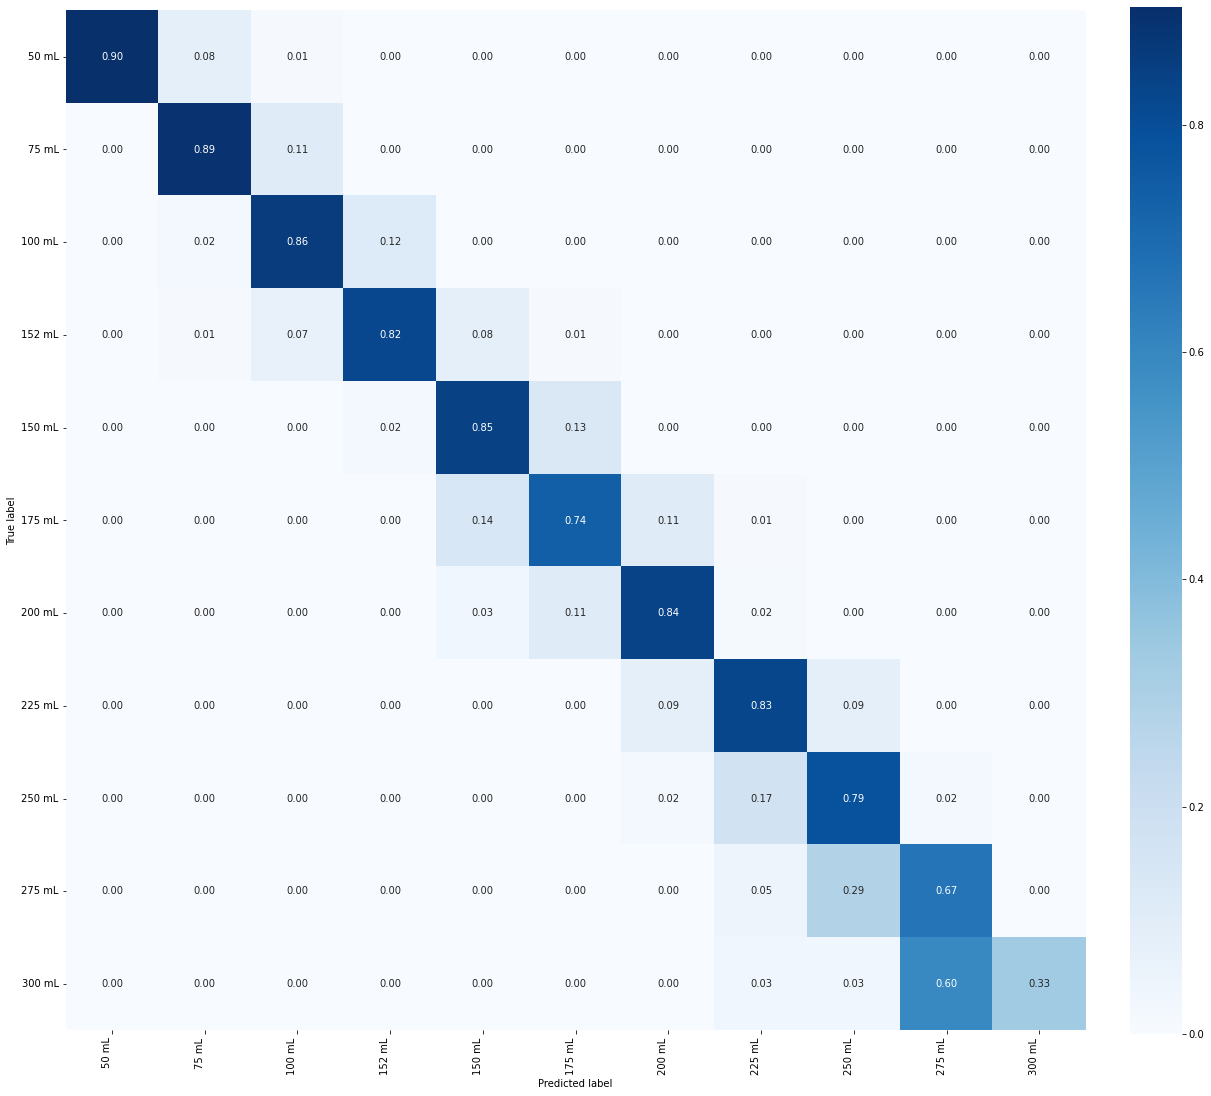

In [5]:
y_true, y_pred = np.array(pred_dict['true_value']), np.array(myround_list(pred_dict['pred_value']))
conf_mat = confusion_matrix(y_true, y_pred, sample_weight=None)
normed_conf = conf_mat / np.sum(conf_mat, axis=1)[:, np.newaxis]

# plt_conf_matrix(conf_mat)
plt_conf_matrix(normed_conf, labels=["50 mL", "75 mL", "100 mL", "152 mL", "150 mL",
                                    "175 mL", "200 mL", "225 mL", "250 mL", "275 mL",
                                    "300 mL"], name='Madrid_copasAll')

## Violin plots

In [93]:
import plotly.graph_objects as go

import pandas as pd

df = pd.DataFrame(data={'true_volume': pred_dict['true_value'], 'pred_volume': pred_dict['pred_value']})
# df = df.astype({"true_volume": type(pred_dict['pred_value'][0])})

fig = go.Figure()

volumes = [50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]
# ['50', '75', '100', '125', '150', '175', '200', '225', '250', '275', '300']
for vol in volumes:
    fig.add_trace(go.Violin(x=df['true_volume'][df['true_volume'] == vol],
                            y=df['pred_volume'][df['true_volume'] == vol],
                            name=vol,
                            box_visible=True,
                            meanline_visible=True))
fig.update_traces(meanline_visible=True,
                  points='all', # show all points
                  jitter=0.05,  # add some jitter on points for better visibility
                  scalemode='count') #scale violin plot area with total count
fig.update_layout(
    title_text="Predicted volumes distribution")
    
fig.write_image("/srv/image-results/violin_plot.png")

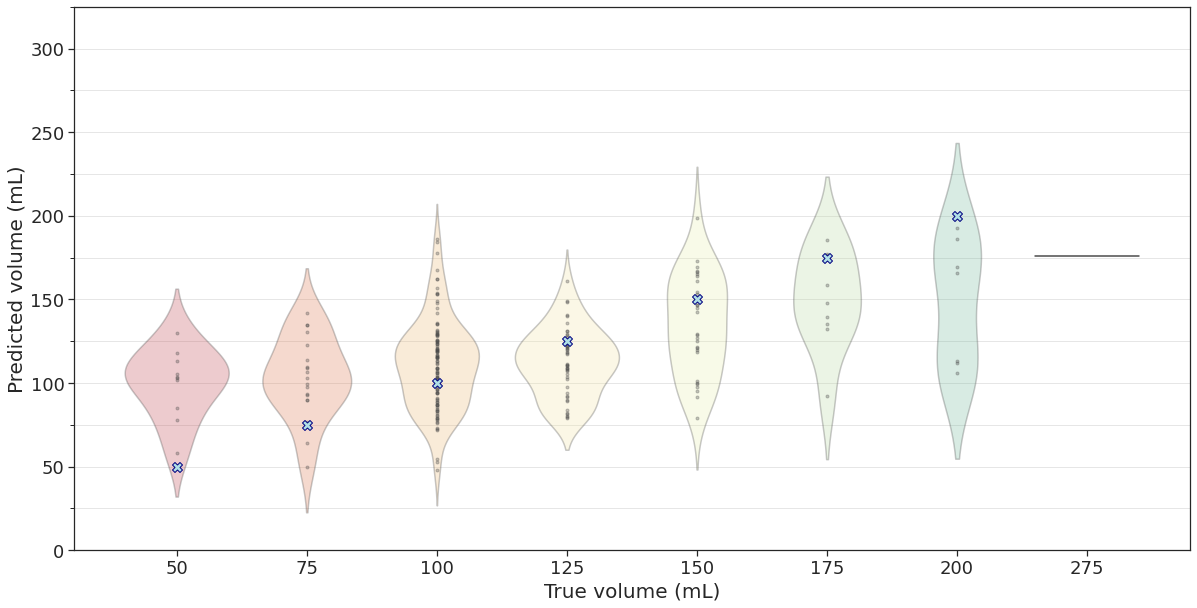

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

plt.rcParams["figure.figsize"] = (20,10)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

sns.set_theme()
sns.set_style(style='white') 

ax = sns.violinplot(x='true_volume', y='pred_volume', data=df, inner="points",
                    palette="Spectral")
ax.set(xlabel='True volume (mL)', ylabel='Predicted volume (mL)')
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)
# sns.boxplot(x='true_volume', y='pred_volume', data=df, palette='rainbow', width=0.3,
#             boxprops={'zorder': 2}, ax=ax)
# plt.title("Predicted volumes distribution", fontsize=22)
# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(MultipleLocator(25))
plt.grid(axis='y', which='both', color='0.9')
# for v in volumes:
#     xrange = np.arange(0, v)
#     plt.plot(xrange, np.ones(xrange.shape) * v)
plt.ylim([0, 325])
plt.setp(ax.collections, alpha=.3)
plt.scatter(x=range(len(volumes)),y=volumes, c="powderblue",  
            marker='X', s=100, edgecolor='navy')
plt.savefig('/srv/image-results/violin_plot_general.pdf',bbox_inches='tight')
plt.show()

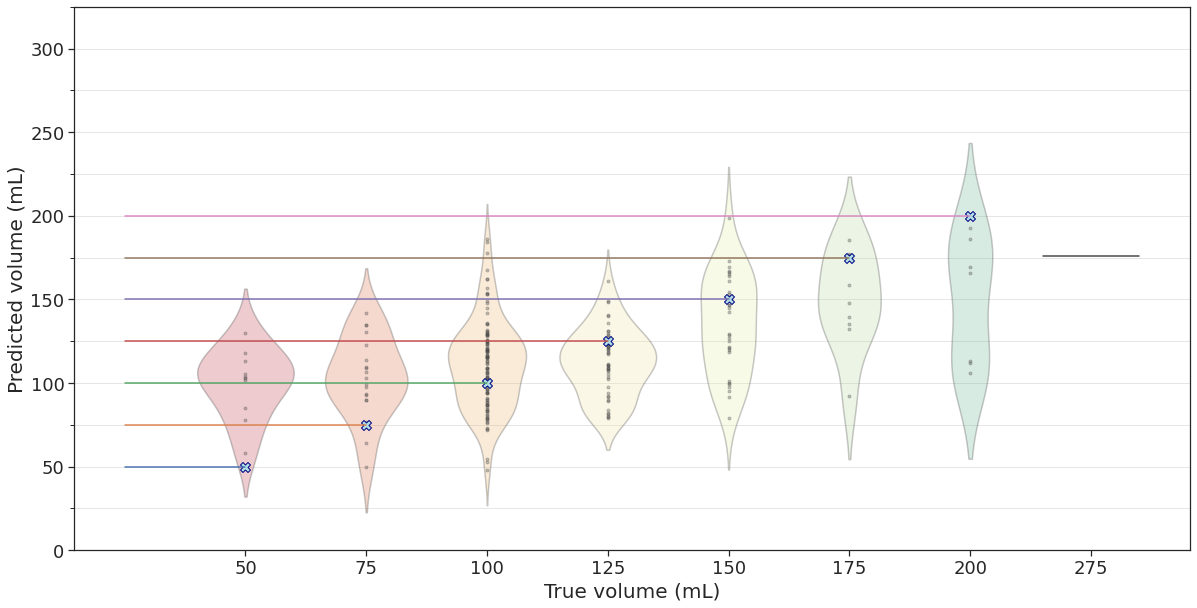

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

plt.rcParams["figure.figsize"] = (20,10)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

sns.set_theme()
sns.set_style(style='white') 

ax = sns.violinplot(x='true_volume', y='pred_volume', data=df, inner="points",
                    palette="Spectral")
ax.set(xlabel='True volume (mL)', ylabel='Predicted volume (mL)')
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)
# sns.boxplot(x='true_volume', y='pred_volume', data=df, palette='rainbow', width=0.3,
#             boxprops={'zorder': 2}, ax=ax)
# plt.title("Predicted volumes distribution", fontsize=22)
# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(MultipleLocator(25))
plt.grid(axis='y', which='both', color='0.9')
for i, v in enumerate(volumes):
    xrange = np.linspace(-1, i, 100)
    ax.plot(xrange, [v]*len(xrange))
plt.ylim([0, 325])
plt.setp(ax.collections, alpha=.3)
plt.scatter(x=range(len(volumes)),y=volumes, c="powderblue",  
            marker='X', s=100, edgecolor='navy')
# plt.savefig('/srv/image-results/violin_plot_general.pdf',bbox_inches='tight')
plt.show()

In [46]:
df[df.isin([275]).any(1)]

,true_volume,pred_volume
88,275,175.703217


In [47]:
df.shape

(229, 2)

In [48]:
extra=df.loc[88]
df.drop(index=88, inplace=True)

In [49]:
df.true_volume.value_counts()

100    109
125     45
150     29
75      19
50      10
175      9
200      7
Name: true_volume, dtype: int64

In [55]:
x=extra.true_volume
y=extra.pred_volume

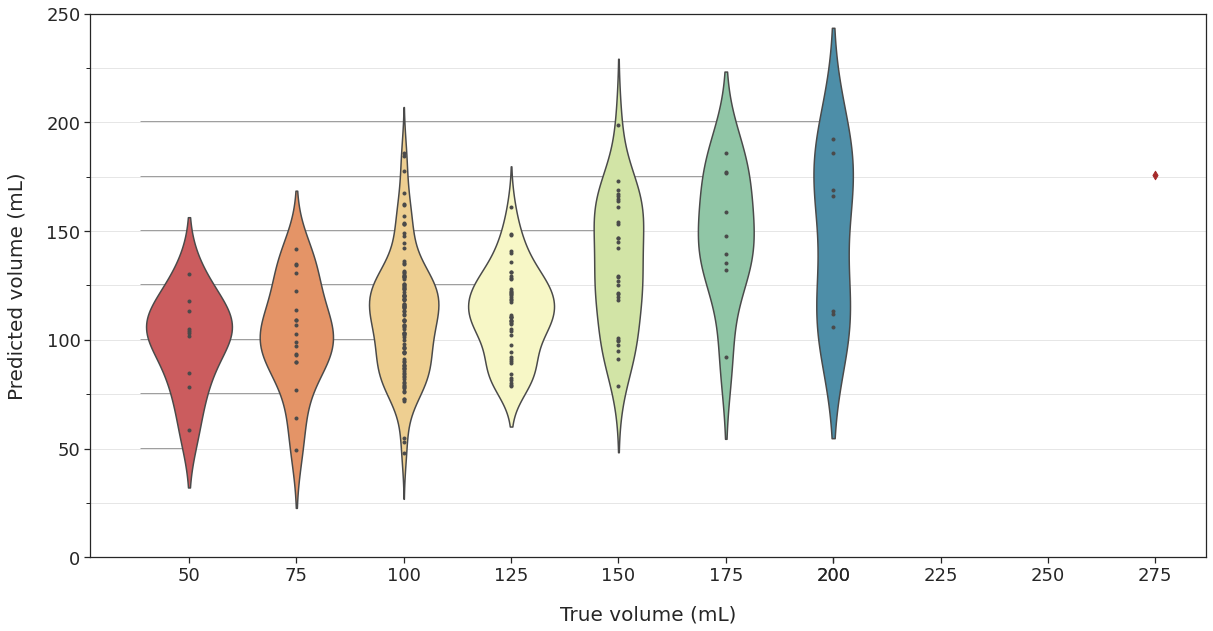

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

sns.set_theme()
sns.set_style(style='white') 

fig, ax = plt.subplots(1,1)
plt.rcParams["figure.figsize"] = (20,10)

    
sns.violinplot(x='true_volume',
                    y='pred_volume',
                    data=df, inner="points",
                    palette="Spectral",
               scatter_kws={"zorder":10},
               ax=ax,
              )

for i, v in enumerate(volumes):
    xrange = np.linspace(-0.45, i, 10)
    ax.plot(xrange, [v]*len(xrange), zorder=-1, color='0.5')
#     sns.lineplot(xrange, [v]*len(xrange), color='0.5', ax=ax)
ax.scatter(i+3,y,marker='d',c="brown")
# ax.set(xlabel='True volume (mL)', ylabel='Predicted volume (mL)')
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
ax.set_xlabel(xlabel='True volume (mL)', labelpad=20, fontsize=20)
ax.set_ylabel(ylabel='Predicted volume (mL)', labelpad=20, fontsize=20)
extraticks=[6, 7, 8, 9]
ax.set_xticks(list(ax.get_xticks()) + extraticks)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[7]='200'
labels[8]='225'
labels[9]='250'
labels[10]='275'
ax.set_xticklabels(labels)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
# sns.boxplot(x='true_volume', y='pred_volume', data=df, palette='rainbow', width=0.3,
#             boxprops={'zorder': 2}, ax=ax)
# plt.title("Predicted volumes distribution", fontsize=22)
# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(MultipleLocator(25))
plt.grid(axis='y', which='both', color='0.9')
plt.rcParams["figure.figsize"] = (20,10)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
    
plt.ylim([0, 250])
plt.setp(ax.collections, alpha=1)
# plt.scatter(x=range(len(volumes)),y=volumes, c="powderblue",              marker='X', s=100, edgecolor='navy')
plt.savefig('/srv/image-results/violin_plot_voluntarios_estudios.png',bbox_inches='tight')
plt.show()

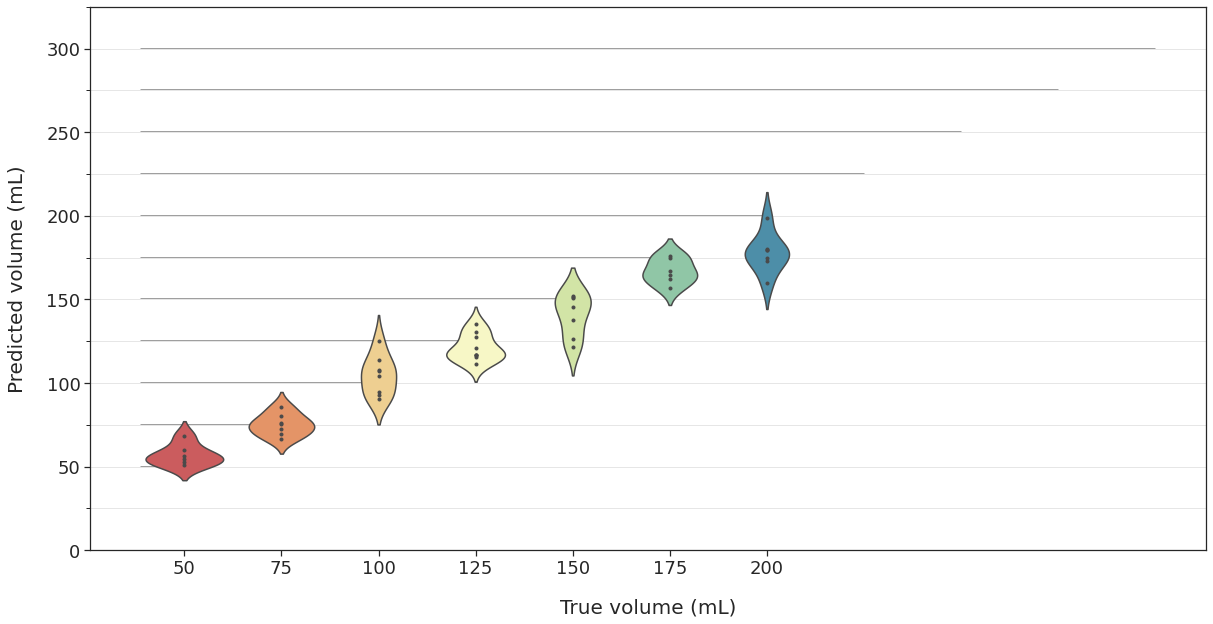

In [94]:


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

sns.set_theme()
sns.set_style(style='white') 

fig, ax = plt.subplots(1,1)
plt.rcParams["figure.figsize"] = (20,10)

    
sns.violinplot(x='true_volume',
                    y='pred_volume',
                    data=df, inner="points",
                    palette="Spectral",
               scatter_kws={"zorder":10},
               ax=ax,
              )

for i, v in enumerate(volumes):
    xrange = np.linspace(-0.45, i, 100)
    ax.plot(xrange, [v]*len(xrange), zorder=-1, color='0.5')
#     sns.lineplot(xrange, [v]*len(xrange), color='0.5', ax=ax)
    
# ax.set(xlabel='True volume (mL)', ylabel='Predicted volume (mL)')
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
ax.set_xlabel(xlabel='True volume (mL)', labelpad=20, fontsize=20)
ax.set_ylabel(ylabel='Predicted volume (mL)', labelpad=20, fontsize=20)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
# sns.boxplot(x='true_volume', y='pred_volume', data=df, palette='rainbow', width=0.3,
#             boxprops={'zorder': 2}, ax=ax)
# plt.title("Predicted volumes distribution", fontsize=22)
# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(MultipleLocator(25))
plt.grid(axis='y', which='both', color='0.9')
plt.rcParams["figure.figsize"] = (20,10)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
    
plt.ylim([0, 325])
plt.setp(ax.collections, alpha=1)
# plt.scatter(x=range(len(volumes)),y=volumes, c="powderblue",              marker='X', s=100, edgecolor='navy')
plt.savefig('/srv/image-results/violin_plot_cuasiRe.png',bbox_inches='tight')
plt.show()

In [30]:
df2 = pd.DataFrame(data={'true_volume': pred_dict['true_value'], 'pred_volume': pred_dict['pred_value'],
                        'filename':pred_dict['filenames']})
pd.set_option('display.max_colwidth', -1)
df2.loc[(df2['true_volume'] == 125) & (df2['pred_volume']<100)]

,true_volume,pred_volume,filename
417,125,99.877281,/srv/datos/Laboratorio/Madrid/copa Char/Fondo azul/Est_Mad_J_Char_125_nd_nf_az_con_me_sup.jpg
498,125,82.510658,/srv/datos/Laboratorio/Madrid/copa Bor/Fondo azul/Est_Mad_J_Bor_125_nd_f_az_con_ce_sup.jpg


In [31]:
df2.loc[(df2['true_volume'] == 175) & (df2['pred_volume']>200)]

,true_volume,pred_volume,filename
631,175,208.034164,/srv/datos/Laboratorio/Madrid/copa Cata/Fondo azul/Est_Mad_J_Cata_175_nd_f_az_con_ce_sup.jpg
682,175,216.949875,/srv/datos/Laboratorio/Madrid/copa Balon/Fondo azul/Est_Mad_J_Balon_175_nd_nf_az_sin_ce_sup.jpg


In [32]:
df2.loc[(df2['true_volume'] == 200) & (df2['pred_volume']<175)]

,true_volume,pred_volume,filename
471,200,148.981949,/srv/datos/Laboratorio/Madrid/copa Bur/Fondo azul/Est_Mad_J_Bur_200_nd_f_az_sin_ce_sup.jpg
667,200,157.793274,/srv/datos/Laboratorio/Madrid/vaso Pinta/Exterior/Est_Mad_J_Pinta_200_nd_ext_nd_nd_me_sup.jpg


In [33]:
df2.loc[(df2['true_volume'] == 250) & (df2['pred_volume']<225)]

,true_volume,pred_volume,filename
22,250,221.436142,/srv/datos/Laboratorio/Madrid/copa Bur/Fondo blanco/Est_Mad_J_Bur_250_nd_nf_bl_sin_ce_sup.jpg
439,250,197.897614,/srv/datos/Laboratorio/Madrid/vaso Pinta/Fondo azul/Est_Mad_J_Pinta_250_nd_nf_az_con_me_sup.jpg


In [35]:
df2.loc[(df2['true_volume'] == 300) & (df2['pred_volume']<275)]

,true_volume,pred_volume,filename
70,300,251.687500,/srv/datos/Laboratorio/Madrid/copa Bor/Exterior/Est_Mad_J_Bor_300_nd_ext_nd_nd_me_inf.jpg
80,300,273.820953,/srv/datos/Laboratorio/Madrid/copa Bur/Fondo azul/Est_Mad_J_Bur_300_nd_f_az_con_me_sup.jpg
102,300,271.134369,/srv/datos/Laboratorio/Madrid/copa Balon/Fondo blanco/Est_Mad_J_Balon_300_nd_nf_bl_sin_me_sup.jpg
127,300,271.528839,/srv/datos/Laboratorio/Madrid/copa Bur/Exterior/Est_Mad_J_Bur_300_nd_ext_nd_nd_al_sup1.jpg
291,300,274.822113,/srv/datos/Laboratorio/Madrid/copa Balon/Fondo blanco/Est_Mad_J_Balon_300_nd_f_bl_sin_al_inf.jpg
335,300,268.610901,/srv/datos/Laboratorio/Madrid/copa Balon/Fondo azul/Est_Mad_J_Balon_300_nd_nf_az_con_ce_sup.jpg
336,300,232.221252,/srv/datos/Laboratorio/Madrid/copa Balon/Fondo azul/Est_Mad_J_Balon_300_nd_nf_az_sin_ce_sup.jpg
445,300,274.840698,/srv/datos/Laboratorio/Madrid/copa Bur/Fondo azul/Est_Mad_J_Bur_300_nd_nf_az_sin_ce_sup1.jpg
534,300,265.015686,/srv/datos/Laboratorio/Madrid/copa Bor/Fondo blanco/Est_Mad_J_Bor_300_nd_f_bl_sin_me_inf.jpg
625,300,272.342346,/srv/datos/Laboratorio/Madrid/copa Balon/Fondo blanco/Est_Mad_J_Balon_300_nd_nf_bl_con_al_sup.jpg


In [9]:
# https://matplotlib.org/stable/gallery/color/named_colors.html colors in matplotlib

In [14]:
# https://stackabuse.com/seaborn-violin-plot-tutorial-and-examples/ interesante sobre
# violin plots
# https://www.linuxtut.com/en/c79c9973a92e1e2c77a7/ # seaborn palletes